Below are some basic performance benchmarks.

These are a bit contrived and might not be a fair test of various packages' strengths.

In [1]:
import random
import math
import sqlite3
import timeit
from collections import namedtuple
from dataclasses import dataclass
from random import shuffle
from matplotlib import pyplot as plt

from ducks import Dex, FrozenDex
from odex import IndexedSet, HashIndex, attr, literal
from odex.index import SortedDictIndex

In [2]:
import platform, psutil, sys

print("platform:\t", platform.system())
print("release:\t", platform.release())
print("architecture:\t", platform.machine())
print("processor:\t", platform.processor())
print("RAM:\t\t", f"{round(psutil.virtual_memory().total / (1024.0 **3))} GB")
print("Python version:\t", sys.version)

platform:	 Darwin
release:	 23.5.0
architecture:	 arm64
processor:	 arm
RAM:		 36 GB
Python version:	 3.12.3 (main, Apr  9 2024, 08:09:14) [Clang 15.0.0 (clang-1500.3.9.4)]


In [3]:
@dataclass(frozen=True)
class X:
    a: int

    def __hash__(self):
        return hash(id(self))
        
def measure(func, n=100):
    timer = timeit.Timer(func)
    return min(timer.repeat(repeat=n, number=1))
    
def lookup(objs):
    iset = IndexedSet(objs, ["a"])

    db = sqlite3.connect(":memory:")
    db.execute("CREATE TABLE objs (id INT PRIMARY KEY, a INT)")
    db.execute("CREATE INDEX idx_a ON objs (a)")
    db.executemany("INSERT INTO objs (id, a) VALUES (?, ?)", [(i, x.a) for i, x in enumerate(objs)])

    dex = Dex(objs, ["a"])

    fdex = FrozenDex(objs, ["a"])

    plan = iset.optimize(iset.plan("a = 0"))
    
    return {
        "odex IndexedSet": measure(lambda: iset.filter("a = 0")),
        "odex IndexedSet (pre-planned)": measure(lambda: iset.execute(plan)),
        "ducks Dex": measure(lambda: set(dex[{"a": 0}])),
        "ducks FrozenDex": measure(lambda: set(fdex[{"a": 0}])),
        "sqlite": measure(lambda: {objs[i] for i, in db.execute("SELECT id FROM objs WHERE a = 0").fetchall()}),
        # "set comprehension": measure(lambda: {x for x in objs if x.a == 0}),
    }
    
def graph(x, data, title, xlabel):
    for key in data[0].keys():
        y = [d[key] * 1000 for d in data]
        plt.plot(x, y, label=key)
    
    plt.xlabel(xlabel)
    plt.ylabel("Time (ms)")
    plt.title(title)
    plt.legend()
    
    plt.show()

In [4]:
n = [1, 10, 100, 1000]
results = [lookup([X(a=j % (100_000//i)) for j in range(100_000)]) for i in n]

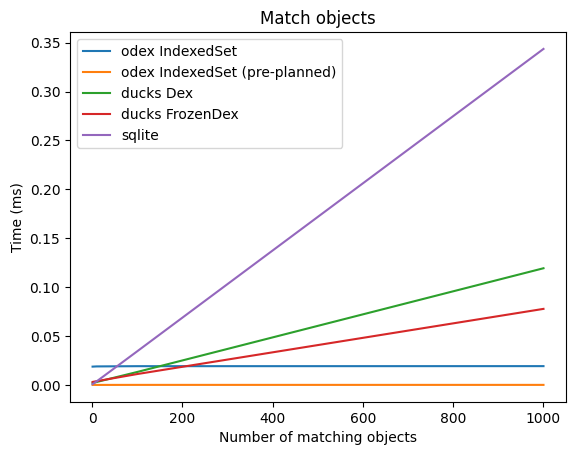

In [5]:
graph(n, results, "Match objects", "Number of matching objects")

Takeaways:
* odex has constant time because it's index is a hash map, and it simply returns the matching set
* odex query planning has overhead

In [6]:
def range_lookup(objs, start, stop):
    iset = IndexedSet(objs, ["a"])

    db = sqlite3.connect(":memory:")
    db.execute("CREATE TABLE objs (id INT PRIMARY KEY, a INT)")
    db.execute("CREATE INDEX idx_a ON objs (a)")
    db.executemany("INSERT INTO objs (id, a) VALUES (?, ?)", [(i, x.a) for i, x in enumerate(objs)])

    dex = Dex(objs, ["a"])
    
    fdex = FrozenDex(objs, ["a"])

    ducks_q = {"a": {">=": start, "<": stop}}

    q = f"a >= {start} AND a < {stop}"
    plan = iset.optimize(iset.plan(q))
    
    return {
        "odex IndexedSet": measure(lambda: iset.filter(q)),
        "odex IndexedSet (pre-planned)": measure(lambda: iset.execute(plan)),
        "ducks Dex": measure(lambda: set(dex[ducks_q])),
        "ducks FrozenDex": measure(lambda: set(fdex[ducks_q])),
        "sqlite": measure(lambda: {objs[i] for i, in db.execute(f"SELECT id FROM objs WHERE a >= {start} AND a < {stop}").fetchall()}),
        "set comprehension": measure(lambda: {x for x in objs if x.a >= start and x.a < stop}),
    }

In [7]:
n = [100, 1000, 10000, 50000]
range_results = [range_lookup([X(a=j) for j in range(100_000)], 0, i) for i in n]

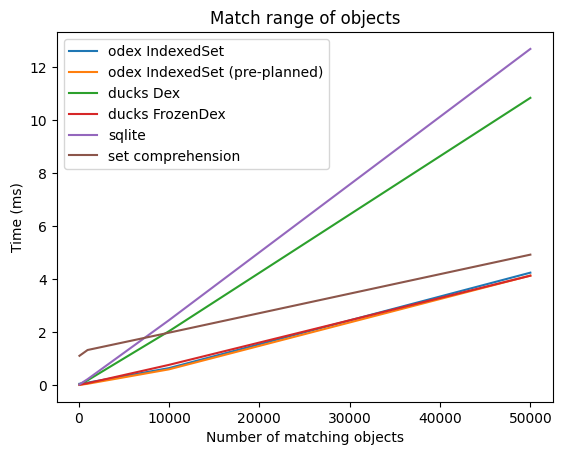

In [8]:
graph(n, range_results, "Match range of objects", "Number of matching objects")

Takeaways:
* odex seems to match ducks FrozenDex on range queries